<h1>Machine Translation</h1>

In [2]:
#Import libraries
import pandas as pd
import string 
import re
import io
import numpy as np
from unicodedata import normalize
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [3]:
#Read the data
def read_data(file):
    data =[]
    with io.open(file, 'r', encoding="utf8") as file:
        for entry in file:
            entry = entry.strip()
            data.append(entry)
    return data

In [4]:
data = read_data('dataset/npi.txt')

In [5]:
data

['Who?\tको?',
 'Hide.\tलुकाउनुहोस्।',
 'Hide.\tलुक।',
 'Stay.\tबस्नुहोस्।',
 'Hello!\tनमस्ते!',
 'Smile.\tमुस्कान।',
 'Attack!\tआक्रमण!',
 'Go slow.\tबिस्तारै जाउ।',
 "I'm Tom.\tम टम हुँ।",
 'I am Tom.\tम टम हुँ।',
 'I danced.\tमैले नाचे।',
 'Who am I?\tम को हु?',
 'Can I eat?\tके म खान सक्छु ?',
 'He is old.\tउहाँ वृद्ध हुनुहुन्छ।',
 'I am okay.\tम ठिक छु।',
 'I am sick.\tम बिरामी छु।',
 'I am sure.\tम पक्का छु।',
 'I am tall.\tम अग्लो छु।',
 'I am well.\tम कुशल छु।',
 "I'm crazy.\tम पागल छु।",
 "I'm crazy.\tम पागल हुँ।",
 "I'm sorry.\tमलाई माफ गर्नुहोस्।",
 'Is it bad?\tयो खराब छ?',
 'Is it bad?\tयो नराम्रो हो?',
 'May I eat?\tके म खान सक्छु ?',
 'Who is he?\tऊ को हो?',
 'Good night.\tशुभ रात्री।',
 'He is lazy.\tऊ अल्छी छ ।',
 'He is nice.\tउहाँ राम्रो हुनुहुन्छ।',
 'He is nice.\tउ राम्रो छ।',
 'He is poor.\tऊ गरिब छ।',
 'He is sick.\tउहाँ बिरामी हुनुहुन्छ।',
 'He is sick.\tऊ बिरामी छ।',
 'How lovely!\tकति प्यारो!',
 'I am a boy.\tम केटा हुँ।',
 'I am a man.\tम एक मानिस हुँ।',
 'I a

In [6]:
len(data)

2405

<h1>Splitting data into English and Nepali</h1>

In [7]:
def build_english_nepali_sentences(data):
    english_sentences = []
    nepali_sentences = []
    for data_point in data:
        english_sentences.append(data_point.split("\t")[0])
        nepali_sentences.append(data_point.split("\t")[1])
    return english_sentences, nepali_sentences

In [8]:
english_sentences, nepali_sentences = build_english_nepali_sentences(data)

In [9]:
len(english_sentences)

2405

In [10]:
len(nepali_sentences)

2405

In [11]:
english_sentences

['Who?',
 'Hide.',
 'Hide.',
 'Stay.',
 'Hello!',
 'Smile.',
 'Attack!',
 'Go slow.',
 "I'm Tom.",
 'I am Tom.',
 'I danced.',
 'Who am I?',
 'Can I eat?',
 'He is old.',
 'I am okay.',
 'I am sick.',
 'I am sure.',
 'I am tall.',
 'I am well.',
 "I'm crazy.",
 "I'm crazy.",
 "I'm sorry.",
 'Is it bad?',
 'Is it bad?',
 'May I eat?',
 'Who is he?',
 'Good night.',
 'He is lazy.',
 'He is nice.',
 'He is nice.',
 'He is poor.',
 'He is sick.',
 'He is sick.',
 'How lovely!',
 'I am a boy.',
 'I am a man.',
 'I am happy.',
 'I am human.',
 'I am human.',
 'I am short.',
 'I am smart.',
 'I eat fish.',
 'I eat here.',
 'I eat meat.',
 'I eat pork.',
 'I eat pork.',
 'I eat rice.',
 'I like you.',
 'I love you.',
 'I miss you.',
 "I'm chubby.",
 "I'm chubby.",
 'Love hurts.',
 'Turn it up.',
 'We are men.',
 'Who is Tom?',
 "Beer's good.",
 "Beer's good.",
 'Have a beer.',
 'He is alone.',
 'He is alone.',
 'He is eight.',
 'He is happy.',
 'He is happy.',
 'Here we are!',
 'Here we are.',

In [12]:
##Data Cleaning
def clean_sentences(sentence):
    #prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))

    #prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    cleaned_sent = normalize('NFD', sentence).encode('ascii', 'ignore')
    cleaned_sent = cleaned_sent.decode('UTF-8')
    cleaned_sent = cleaned_sent.split()
    cleaned_sent = [word.lower() for word in cleaned_sent]
    cleaned_sent = [word.translate(table) for word in cleaned_sent]
    cleaned_sent = [re_print.sub('', w) for w in cleaned_sent]
    cleaned_sent = [word for word in cleaned_sent if word.isalpha()]
    return ' '.join(cleaned_sent)

In [13]:
def build_clean_english_nepali_sentences(english_sentences, nepali_sentences):
    nepali_sentences_cleaned = []
    english_sentences_cleaned = []
    for sent in nepali_sentences:
        nepali_sentences_cleaned.append(clean_sentences(sent))
    for sent in english_sentences:
        english_sentences_cleaned.append(clean_sentences(sent))
    return english_sentences_cleaned, nepali_sentences_cleaned

In [14]:
english_sentences_cleaned, nepali_sentences_cleaned = build_clean_english_nepali_sentences(english_sentences, nepali_sentences)

In [15]:
english_sentences_cleaned[100]

'i am chinese'

In [16]:
nepali_sentences

['को?',
 'लुकाउनुहोस्।',
 'लुक।',
 'बस्नुहोस्।',
 'नमस्ते!',
 'मुस्कान।',
 'आक्रमण!',
 'बिस्तारै जाउ।',
 'म टम हुँ।',
 'म टम हुँ।',
 'मैले नाचे।',
 'म को हु?',
 'के म खान सक्छु ?',
 'उहाँ वृद्ध हुनुहुन्छ।',
 'म ठिक छु।',
 'म बिरामी छु।',
 'म पक्का छु।',
 'म अग्लो छु।',
 'म कुशल छु।',
 'म पागल छु।',
 'म पागल हुँ।',
 'मलाई माफ गर्नुहोस्।',
 'यो खराब छ?',
 'यो नराम्रो हो?',
 'के म खान सक्छु ?',
 'ऊ को हो?',
 'शुभ रात्री।',
 'ऊ अल्छी छ ।',
 'उहाँ राम्रो हुनुहुन्छ।',
 'उ राम्रो छ।',
 'ऊ गरिब छ।',
 'उहाँ बिरामी हुनुहुन्छ।',
 'ऊ बिरामी छ।',
 'कति प्यारो!',
 'म केटा हुँ।',
 'म एक मानिस हुँ।',
 'म खुशी छु।',
 'म मानव हुँ।',
 'म मान्छे हुँ।',
 'म होचो छु।',
 'म स्मार्ट छु।',
 'म माछा खान्छु।',
 'म यहाँ खान्छु।',
 'म मासु खान्छु।',
 'म सुँगुरको मासु खान्छु।',
 'म पोर्क खान्छु।',
 'म भात खान्छु।',
 'म तिमीलाई मन पराउँछु।',
 'म तिमीलाई माया गर्छु।',
 'म तिमीलाई सम्झन्छु।',
 'म मोटो छु।',
 'म मोटी छु।',
 'मायाले दुख दिन्छ।',
 'अलिक ठूलो बनाउनुहोस्।',
 'हामी पुरुष हौं।',
 'टम को हो?',
 'बियर राम्रो ह

In [30]:
##Building input and target datasets
def build_data(english_sentences_cleaned, nepali_sentences):
    input_dataset = []
    target_dataset = []
    input_characters = set()
    target_characters = set()

    for nepali_sentence in nepali_sentences:
        input_datapoint = nepali_sentence
        print(input_datapoint)
        input_dataset.append(input_datapoint)
        for char in input_datapoint:
            print('char ' + char)
            input_characters.add(char)

    for english_sentence in english_sentences_cleaned:
        target_datapoint = "\t" + english_sentence + "\n"
        target_dataset.append(target_datapoint)
        for char in target_datapoint:
            target_characters.add(char)

    return input_dataset, target_dataset, sorted(list(input_characters)), sorted(list(target_characters))

In [31]:
input_dataset, target_dataset, input_characters, target_characters = build_data(english_sentences_cleaned, nepali_sentences)

को?
char क
char ो
char ?
लुकाउनुहोस्।
char ल
char ु
char क
char ा
char उ
char न
char ु
char ह
char ो
char स
char ्
char ।
लुक।
char ल
char ु
char क
char ।
बस्नुहोस्।
char ब
char स
char ्
char न
char ु
char ह
char ो
char स
char ्
char ।
नमस्ते!
char न
char म
char स
char ्
char त
char े
char !
मुस्कान।
char म
char ु
char स
char ्
char क
char ा
char न
char ।
आक्रमण!
char आ
char क
char ्
char र
char म
char ण
char !
बिस्तारै जाउ।
char ब
char ि
char स
char ्
char त
char ा
char र
char ै
char  
char ज
char ा
char उ
char ।
म टम हुँ।
char म
char  
char ट
char म
char  
char ह
char ु
char ँ
char ।
म टम हुँ।
char म
char  
char ट
char म
char  
char ह
char ु
char ँ
char ।
मैले नाचे।
char म
char ै
char ल
char े
char  
char न
char ा
char च
char े
char ।
म को हु?
char म
char  
char क
char ो
char  
char ह
char ु
char ?
के म खान सक्छु ?
char क
char े
char  
char म
char  
char ख
char ा
char न
char  
char स
char क
char ्
char छ
char ु
char  
char ?
उहाँ वृद्ध हुनुहुन्छ।
char उ
char ह
char ा
char ँ
char  
ch

In [35]:
input_characters

[' ',
 '!',
 '"',
 ',',
 '-',
 '0',
 '2',
 '3',
 ':',
 '?',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ए',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'े',
 'ै',
 'ो',
 'ौ',
 '्',
 '।',
 '०',
 '१',
 '२',
 '३',
 '४',
 '९',
 '\u200b',
 '\u200d']

In [20]:
len(target_characters)

69033

In [33]:
target_characters

['\t',
 '\n',
 ' ',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [36]:
##Defining metadata
def build_metadata(input_dataset, target_dataset, input_characters, target_characters):
    num_Encoder_tokens = len(input_characters)
    num_Decoder_tokens = len(target_characters)
    max_Encoder_seq_length = max([len(data_point) for data_point in input_dataset])
    max_Decoder_seq_length = max([len(data_point) for data_point in target_dataset])
    print('Number of data points:', len(input_dataset))
    print('Number of unique input tokens:', num_Encoder_tokens)
    print('Number of unique output tokens:', num_Decoder_tokens)
    print('Maximum sequence lenght for inputs:', max_Encoder_seq_length)
    print('Maximum sentence lenght for outputs:', max_Decoder_seq_length)
    return num_Encoder_tokens, num_Decoder_tokens, max_Encoder_seq_length, max_Decoder_seq_length

In [37]:
num_Encoder_tokens, num_Decoder_tokens, max_Encoder_seq_length, max_Decoder_seq_length = build_metadata(input_dataset, target_dataset, input_characters, target_characters)

Number of data points: 2405
Number of unique input tokens: 76
Number of unique output tokens: 29
Maximum sequence lenght for inputs: 102
Maximum sentence lenght for outputs: 123


Mapping characters

In [39]:
def build_indices(input_characters, target_characters):
    input_char_to_idx = {}
    input_idx_to_char = {}
    target_char_to_idx = {}
    target_idx_to_char = {}

    for i, char in enumerate(input_characters):
        input_char_to_idx[char] = i
        input_idx_to_char[i] = char

    for i, char in enumerate(target_characters):
        target_char_to_idx[char] = i
        target_idx_to_char[i] = char

    return input_char_to_idx, input_idx_to_char, target_char_to_idx, target_idx_to_char

In [40]:
input_char_to_idx, input_idx_to_char, target_char_to_idx, target_idx_to_char = build_indices(input_characters, target_characters)

Build Data Structure

In [41]:
def build_data_structures(length_input_dataset, max_Encoder_seq_length,max_Decoder_seq_length, num_Encoder_tokens, num_Decoder_tokens):
    Encoder_input_data = np.zeros((length_input_dataset, max_Encoder_seq_length, num_Encoder_tokens), dtype='float32')
    Decoder_input_data = np.zeros((length_input_dataset, max_Decoder_seq_length, num_Decoder_tokens), dtype='float32')
    Decoder_target_data = np.zeros((length_input_dataset, max_Decoder_seq_length, num_Decoder_tokens), dtype='float32')
    print("Dimensionality of Encoder input data is : ", Encoder_input_data.shape)
    print("Dimensionality of Decoder input data is : ", Decoder_input_data.shape)
    print("Dimensionality of Decoder target data is : ", Decoder_target_data.shape)
    return Encoder_input_data, Decoder_input_data, Decoder_target_data

In [42]:
Encoder_input_data, Decoder_input_data, Decoder_target_data = build_data_structures(len(input_dataset), max_Encoder_seq_length, max_Decoder_seq_length, num_Encoder_tokens, num_Decoder_tokens)

Dimensionality of Encoder input data is :  (2405, 102, 76)
Dimensionality of Decoder input data is :  (2405, 123, 29)
Dimensionality of Decoder target data is :  (2405, 123, 29)


Add Data to Data Structure

In [43]:
def add_data_to_data_structures(input_dataset, target_dataset, Encoder_input_data, Decoder_input_data, Decoder_target_data):
    for i, (input_data_point, target_data_point) in enumerate(zip(input_dataset, target_dataset)):
        for t, char in enumerate(input_data_point):
            Encoder_input_data[i, t, input_char_to_idx[char]] = 1.
        for t, char in enumerate(target_data_point):
            # Decoder_target_data is ahead of Decoder_input_data by
            # one timestep
            Decoder_input_data[i, t, target_char_to_idx[char]] = 1.
            if t > 0:
                # Decoder_target_data will be ahead by one timestep and will not include the start character.
                Decoder_target_data[i, t - 1, target_char_to_idx[char]] = 1.
    
    return Encoder_input_data, Decoder_input_data, Decoder_target_data

In [44]:
Encoder_input_data, Decoder_input_data, Decoder_target_data = add_data_to_data_structures(input_dataset, target_dataset, Encoder_input_data, Decoder_input_data, Decoder_target_data)

In [45]:
#Defining hyperparameters for model
batch_size = 256
epochs = 100
latent_dim = 256

In [46]:
##Define Encoder
Encoder_inputs = Input(shape=(None, num_Encoder_tokens))
Encoder = LSTM(latent_dim, return_state=True)
Encoder_outputs, state_h, state_c = Encoder(Encoder_inputs)
Encoder_states = [state_h, state_c] ##hidden state and memory cell

In [47]:
##Define Decoder
Decoder_inputs = Input(shape=(None, num_Decoder_tokens))
Decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
Decoder_outputs, _, _ = Decoder_lstm(Decoder_inputs, initial_state=Encoder_states)
Decoder_dense = Dense(num_Decoder_tokens, activation='softmax')
Decoder_outputs = Decoder_dense(Decoder_outputs)

Training the model

In [48]:
model = Model(inputs=[Encoder_inputs, Decoder_inputs], outputs=Decoder_outputs)

In [49]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 76)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 29)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                340992    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                             

In [64]:
history = model.fit([Encoder_input_data, Decoder_input_data], Decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 15s 2s/step - loss: 0.5581 - val_loss: 1.0792
Epoch 2/100
8/8 [==============================] - 14s 2s/step - loss: 0.5585 - val_loss: 1.0814
Epoch 3/100
8/8 [==============================] - 15s 2s/step - loss: 0.5573 - val_loss: 1.0797
Epoch 4/100
8/8 [==============================] - 15s 2s/step - loss: 0.5566 - val_loss: 1.0724
Epoch 5/100
8/8 [==============================] - 15s 2s/step - loss: 0.5555 - val_loss: 1.0787
Epoch 6/100
8/8 [==============================] - 15s 2s/step - loss: 0.5561 - val_loss: 1.0676
Epoch 7/100
8/8 [==============================] - 15s 2s/step - loss: 0.5563 - val_loss: 1.0700
Epoch 8/100
8/8 [==============================] - 15s 2s/step - loss: 0.5571 - val_loss: 1.0716
Epoch 9/100
8/8 [==============================] - 14s 2s/step - loss: 0.5558 - val_loss: 1.0708
Epoch 10/100
8/8 [==============================] - 15s 2s/step - loss: 0.5557 - val_loss: 1.0705
Epoch 11/100
8/8 [===========

In [65]:
##Saving the Model
model.save('OutputFiles/machine_translation_english_to_nepali.h5')

c:\Program Files\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
Encoder_model = Model(Encoder_inputs, Encoder_states)
Decoder_state_input_c = Input(shape=(latent_dim,))
Decoder_state_input_h = Input(shape=(latent_dim,))
Decoder_states_inputs = [Decoder_state_input_h, Decoder_state_input_c]
Decoder_outputs, state_h, state_c = Decoder_lstm(Decoder_inputs, initial_state=Decoder_states_inputs)
Decoder_states = [state_h, state_c]
Decoder_outputs = Decoder_dense(Decoder_outputs)
Decoder_model = Model([Decoder_inputs] + Decoder_states_inputs,
[Decoder_outputs] + Decoder_states)

In [67]:
##Decoding method
def decode_sequence(input_seq):
    states_value = Encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_Decoder_tokens))
    target_seq[0, 0, target_char_to_idx['\t']] = 1.
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = Decoder_model.predict([target_seq]+ states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_idx_to_char[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '\n' or len(decoded_sentence) > max_Decoder_seq_length):
            stop_condition = True
            
        target_seq = np.zeros((1, 1, num_Decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c]
    return decoded_sentence

In [68]:
##Translate
def decode(seq_index):
    input_seq = Encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_dataset[seq_index])
    print('Decoded sentence:', decoded_sentence)

In [55]:
decode(100)

1/1 [==============================] - 0s 28ms/step
-
Input sentence: म चाइनिज हुँ।
Decoded sentence: i don  t oonnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


In [56]:
decode(50)

1/1 [==============================] - 0s 16ms/step
-
Input sentence: म मोटो छु।
Decoded sentence: i don  t oonnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Evaluate The Model

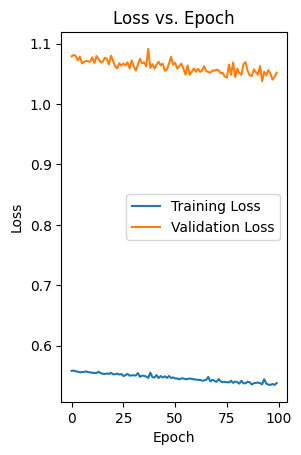

In [70]:
import matplotlib.pyplot as plt 
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()